# Semantic Code Search using Transformers and BERT - Part II
Author - Shashank Ramesh

Part-II uses docstrings from the data collected and processed in part-I and converts them to vectors using ALBERT.

## Converting Docstrings to vectors
This notebook contains steps to fine-tune ALBERT model to generate docstring vectors

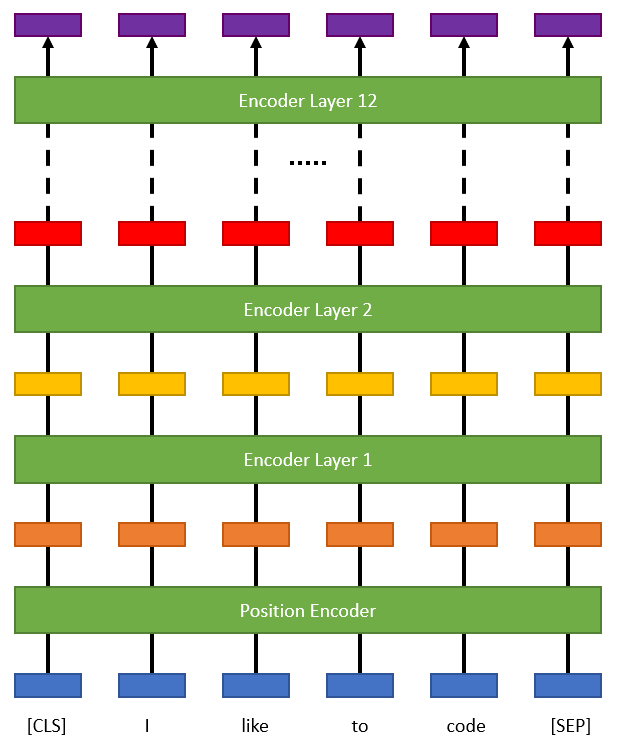

In [1]:
#importing libraries
import numpy as np
import math
import random
import tensorflow as tf
import torch
import csv
import pandas as pd
import transformers
from transformers import  AlbertConfig,TFAlbertModel
from transformers import AlbertTokenizer
from transformers import  AlbertConfig,TFAlbertModel

### Creating training data to fine-tune ALBERT
For incremental training on a pre-trained ALBERT model we need to process our docstrings for the model to train on. We need to generate masks and create sentence pairs for the model to train on using the n-gram Masked Language Modelling and Sentence Order Prediction tasks 

In [2]:
!python "./create_pretraining_data.py" \
  --input_file  "./docstrings.txt" \
  --output_file  "./tf_examples" \
  --vocab_file  "./30k-clean.vocab" \
  --spm_model_file "./30k-clean.model" \
  --do_lower_case True \
  --max_seq_length 50 \
  --max_predictions_per_seq 8 \
  --random_seed 12345 \
  --dupe_factor 5


W0522 21:01:59.654605 140550058289024 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/albert/tokenization.py:240: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.

INFO:tensorflow:loading sentence piece model
I0522 21:01:59.654801 140550058289024 tokenization.py:240] loading sentence piece model
INFO:tensorflow:*** Reading from input files ***
I0522 21:01:59.730216 140550058289024 create_pretraining_data.py:631] *** Reading from input files ***
INFO:tensorflow:  /content/drive/My Drive/BERT Training/docstrings.txt
I0522 21:01:59.730445 140550058289024 create_pretraining_data.py:633]   /content/drive/My Drive/BERT Training/docstrings.txt
INFO:tensorflow:number of instances: 1720445
I0522 21:22:03.437951 140550058289024 create_pretraining_data.py:641] number of instances: 1720445
INFO:tensorflow:*** Writing to output files ***
I0522 21:22:03.438693 140550058289024 create_pretraining_data.py:644] *** Writing to output files ***
INFO

### Running incremental training to fine-tune ALBERT
Once we have generated the training data from the above process we can begin the training process by running the run_pretraining.py file.

In [3]:
!python "./run_pretraining.py" \
    --input_file "./tf_examples" \
    --output_dir "./model" \
    --init_checkpoint "./bert_model.ckpt" \
    --albert_config_file "./albert_config.json" \
    --do_train \
    --do_eval \
    --train_batch_size=64 \
    --eval_batch_size=32 \
    --max_seq_length 50 \
    --max_predictions_per_seq 8 \
    --optimizer 'lamb' \
    --learning_rate .00176 \
    --num_train_steps 100000 \
    --num_warmup_steps 1000 \
    --save_checkpoints_steps 10000



W0523 13:42:04.451838 139802773264256 module_wrapper.py:139] From /usr/local/lib/python3.6/dist-packages/albert/modeling.py:116: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

INFO:tensorflow:*** Input Files ***
I0523 13:42:04.454887 139802773264256 run_pretraining.py:484] *** Input Files ***
INFO:tensorflow:  /content/drive/My Drive/BERT Training/tf_examples
I0523 13:42:04.455017 139802773264256 run_pretraining.py:486]   /content/drive/My Drive/BERT Training/tf_examples
W0523 13:42:04.455364 139802773264256 estimator.py:1994] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7f25ec3b31e0>) includes params argument, but params are not passed to Estimator.
INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/BERT Training/model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrit

### Converting Tensorflow Checkpoint file to Pytorch dump
To use the HuggingFace library to realize our trained ALBERT model we need to convert our tensorflow checkpoint file to a pytorch dump.

In [4]:
import logging
import torch
from transformers import AlbertConfig, AlbertForPreTraining, load_tf_weights_in_albert


logging.basicConfig(level=logging.INFO)


def convert_tf_checkpoint_to_pytorch(tf_checkpoint_path, albert_config_file, pytorch_dump_path):
    # Initialise PyTorch model
    config = AlbertConfig.from_json_file(albert_config_file)
    print("Building PyTorch model from configuration: {}".format(str(config)))
    model = AlbertForPreTraining(config)

    # Load weights from tf checkpoint
    load_tf_weights_in_albert(model, config, tf_checkpoint_path)

    # Save pytorch-model
    print("Save PyTorch model to {}".format(pytorch_dump_path))
    torch.save(model.state_dict(), pytorch_dump_path)



convert_tf_checkpoint_to_pytorch('model.ckpt-100000','albert_config.json' , 'pytorch_model.bin')

Building PyTorch model from configuration: AlbertConfig {
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30000
}



INFO:transformers.modeling_albert:Converting TensorFlow checkpoint from /content/drive/My Drive/BERT Training/model/model.ckpt-100000
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/LayerNorm/beta with shape [128]
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/LayerNorm/beta/adam_m with shape [128]
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/LayerNorm/beta/adam_v with shape [128]
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/LayerNorm/gamma with shape [128]
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/LayerNorm/gamma/adam_m with shape [128]
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/LayerNorm/gamma/adam_v with shape [128]
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/position_embeddings with shape [512, 128]
INFO:transformers.modeling_albert:Loading TF weight bert/embeddings/position_embeddings/adam_m with shape [512, 128]
INFO:tra

bert/embeddings/LayerNorm/beta
bert/embeddings/LayerNorm/beta/adam_m
bert/embeddings/LayerNorm/beta/adam_v
bert/embeddings/LayerNorm/gamma
bert/embeddings/LayerNorm/gamma/adam_m
bert/embeddings/LayerNorm/gamma/adam_v
bert/embeddings/position_embeddings
bert/embeddings/position_embeddings/adam_m
bert/embeddings/position_embeddings/adam_v
bert/embeddings/token_type_embeddings
bert/embeddings/token_type_embeddings/adam_m
bert/embeddings/token_type_embeddings/adam_v
bert/embeddings/word_embeddings
bert/embeddings/word_embeddings/adam_m
bert/embeddings/word_embeddings/adam_v
bert/encoder/embedding_hidden_mapping_in/bias
bert/encoder/embedding_hidden_mapping_in/bias/adam_m
bert/encoder/embedding_hidden_mapping_in/bias/adam_v
bert/encoder/embedding_hidden_mapping_in/kernel
bert/encoder/embedding_hidden_mapping_in/kernel/adam_m
bert/encoder/embedding_hidden_mapping_in/kernel/adam_v
bert/encoder/transformer/group_0/inner_group_0/LayerNorm/beta
bert/encoder/transformer/group_0/inner_group_0/Laye

### Creating the trained ALBERT model
Now that we have our pytorch_model.bin file with few steps we can make a functional model to help us generate embeddings for our docstrings.

In [5]:
# Getting the albert tokenizer from HuggingFace library
albert_tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2') 

In [6]:
# Loading the weights and the configuration of our trained ALBERT model
config = AlbertConfig.from_pretrained('./albert', output_hidden_states=True)

model = TFAlbertModel.from_pretrained('./albert', config=config,  from_pt=True)
print(model.config)

AlbertConfig {
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "output_hidden_states": true,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30000
}



### Generating Embeddings for Docstrings
Now that our ALBERT model is ready we can churn out some docstring vectors from it.

In [7]:
# Load the train data
train_df = pd.read_csv('train_sorted.csv')

In [8]:
# Number of docstrings
print(len(train_df['docstring'].values))

996341


In [9]:
avg_embeddings = []
for count,item in enumerate(train_df['docstring'].values): #traverse thorugh all train data set docstrings
    e = albert_tokenizer.encode(item, max_length=512)
    input = tf.constant(e)[None, :]  # Batch size 1 
    output = model(input)
    v = [0]*768
    for i in range(1, len(input[0])-1):
        v = v + output[0][0][i].numpy()  # generate sentence vectors by averaging the word vectors
    avg_embeddings.append(v/len(input[0])) #append all sentence vectors into a list

In [10]:
# Save the sentence embeddings in a .tsv file
with open("avg_embeddings.tsv","w+",newline='') as my_csv:
    csvWriter = csv.writer(my_csv,delimiter='\t')
    csvWriter.writerows(avg_embeddings)